
# Objetivo 2: Generación de modelos

Pipeline completo para la predicción del crecimiento de datos de biodiversidad en GBIF.

Este script implementa el flujo de trabajo de principio a fin para modelar datos de panel
de series temporales, incluyendo:
1.  Carga datos de PA_dataAnalysis y preparación
2.  Ingeniería de características temporales (lags y ventanas móviles).
3.  Un marco de validación cruzada robusto para series de tiempo (ventana expansiva).
4.  Preprocesamiento (imputación y escalado) dentro del bucle de validación para evitar fuga de datos.
5.  Entrenamiento y evaluación comparativa de cuatro modelos:
    - Prophet.
    - Random Forest.
    - XGBoost.
    - Red Neuronal LSTM (para modelado secuencial).

6.  Selección del mejor modelo basado en métricas de rendimiento (MAE, RMSE, R²).
7.  Reentrenamiento del modelo final y generación de pronósticos para Colombia hasta 2030
    bajo dos escenarios de políticas.

In [1]:
# =============================================================================
# 1. IMPORTACIÓN DE LIBRERÍAS Y CONFIGURACIÓN INICIAL
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm

# Preprocesamiento y modelado de Scikit-Learn
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split


# Modelos especializados

import xgboost as xgb
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

# Modelado de Deep Learning con TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


# Configuraciones generales
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)

Importing plotly failed. Interactive plots will not work.
2025-11-02 10:32:18.989899: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# =============================================================================
# 2. CARGA Y PREPARACIÓN DE DATOS
# =============================================================================
url = "https://raw.githubusercontent.com/rortizgeo/Maestria_CD_Proyecto-Aplicado/main/Data_final.csv"
Data_final = pd.read_csv(url)

Data_final['ds'] = pd.to_datetime(Data_final['year'], format='%Y')
Data_final = Data_final.sort_values(by=['country', 'ds']).reset_index(drop=True)

TARGET = 'occurrenceCount_publisher'
Data_final[TARGET] = np.log1p(Data_final[TARGET])
print("Transformación log1p aplicada al target.")

columns_to_drop = ['Overall score', 'areas_protegidas', 'countryCode']
Data_final = Data_final.drop(columns=columns_to_drop)

features_total = ['country', 'year', 'ds', 'superficie_total_km2', 'gasto_RD_pib', 'efectividad_gobierno', 'uso_internet', 'pib_per_capita', 'Overall score', 'region', 'incomeLevel', 'occurrenceCount_publisher', 'gbif_member', 'ogp_membership', 'PC1', 'PC2', 'PC3']

Transformación log1p aplicada al target.


Para aplicar modelos como Random Forest y XGBoost, es necesario agregar características de temporalidad en los datos, para lo cuál es necesario calcular retardos, que se deben aplicar teniendo en cuenta un análisis del ACF Y PACF, así como la incorporación de los tiempos del retardo como hiperparámetros. 

Los modelos basados en árboles como Random Forest y XGBoost no son conscientes de la secuencia temporal de los datos y no pueden "extrapolar" tendencias más allá de los valores que han visto en el entrenamiento. Por lo tanto, es necesario convertir la información temporal en características que el modelo pueda entender. La creación de retardos (lags) y estadísticas de ventana móvil es la técnica estándar para lograrlo. Se podría identificar el número de retardos como un hiperparámetro, guiado por análisis de ACF y PACF (Ver EDA)

In [3]:
# =============================================================================
# 3. INGENIERÍA DE CARACTERÍSTICAS TEMPORALES
# =============================================================================
def create_temporal_features_optimized(data, features_to_lag, lags=[], roll_windows=[]):
    df_copy = data.copy()
    for feature in features_to_lag:
        for lag in lags:
            df_copy[f'{feature}_lag{lag}'] = df_copy.groupby('country')[feature].shift(lag)
        for w in roll_windows:
            df_copy[f'{feature}_rollmean{w}'] = df_copy.groupby('country')[feature].shift(1).rolling(window=w, min_periods=1).mean()
            df_copy[f'{feature}_rollstd{w}'] = df_copy.groupby('country')[feature].shift(1).rolling(window=w, min_periods=1).std()
    return df_copy

features_to_lag = ['gasto_RD_pib', 'efectividad_gobierno', 'uso_internet', 'pib_per_capita', 'occurrenceCount_publisher', 
                   'gbif_member', 'ogp_membership', 'PC1', 'PC2', 'PC3'
]
df_featured = create_temporal_features_optimized(
    Data_final,
    features_to_lag=features_to_lag,
    lags=[1, 3, 5],
    roll_windows=[1, 3, 5]
)
print("Ingeniería de características completada.")

Ingeniería de características completada.


In [4]:
# =============================================================================
# 4. PREPARACIÓN DE DATOS BASE PARA MODELOS (SIN ESCALADO GLOBAL)
# =============================================================================
# A. RandomForest y XGBoost (modelos tabulares)
features_tabular = [f for f in df_featured.columns if f not in ['ds', 'year', 'country', TARGET]]
X_tab = df_featured[features_tabular].copy()
y_tab = df_featured[TARGET].copy()

# B. LSTM (modelos secuenciales)
def create_lstm_sequences_global(df, features, target, look_back=3):
    X_seq, y_seq, years, countries = [], [], [], []
    for country in df['country'].unique():
        df_country = df[df['country'] == country].sort_values('year')
        X_country = df_country[features].values.astype(np.float32)
        y_country = df_country[target].values.astype(np.float32)
        years_country = df_country['year'].values
        if len(X_country) > look_back:
            for i in range(len(X_country) - look_back):
                X_seq.append(X_country[i:(i + look_back)])
                y_seq.append(y_country[i + look_back])
                years.append(years_country[i + look_back])
                countries.append(country)
    return np.array(X_seq), np.array(y_seq), np.array(years), np.array(countries)

columnas_a_excluir_lstm = ['country', TARGET, 'ds']
features_lstm = [f for f in features_total if f not in columnas_a_excluir_lstm]
features_lstm = [f for f in features_lstm if f in Data_final.columns]
look_back = 3
X_seq, y_seq, years_seq, countries_seq = create_lstm_sequences_global(Data_final, features=features_lstm, target=TARGET, look_back=look_back)

# C. Prophet (modelo de series temporales)
columnas_a_excluir_p = ['country', TARGET, 'ds', 'year']
regressors_prophet = [f for f in features_total if f not in columnas_a_excluir_p]
regressors_prophet = [r for r in regressors_prophet if r in df_featured.columns]
df_prophet_base = df_featured[['ds', TARGET] + regressors_prophet].rename(columns={TARGET: 'y'})







In [14]:
# =============================================================================
# 5. DEFINICIÓN DE HIPERPARÁMETROS Y FUNCIONES DE OPTIMIZACIÓN
# =============================================================================
# (Las funciones de optimización y definición de hiperparámetros no cambian, se mantienen como en el original)
# 🌲 Random Forest (Mayor rango de complejidad y submuestreo)
rf_param_dist = {
    "n_estimators": [100, 300, 500, 700],
    "max_depth": [10, 20, 40, None], # Más profundidad
    "min_samples_leaf": [1, 2, 5, 10],
    "max_features": [0.7, 0.9, 'sqrt'] # Submuestreo de features
}

# 🚀 XGBoost (Añadir regularización L1/L2 y submuestreo por columna)
xgb_param_dist = {
    "n_estimators": [100, 300, 500, 700],
    "max_depth": [3, 5, 7, 9],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "gamma": [0, 0.1, 0.5], # Parámetro de regularización
    "reg_alpha": [0, 0.005, 0.1] # Regularización L1
}



# 🧠 LSTM (Añadir activación, más unidades y control de learning rate)
lstm_param_grid = [
    {"units": 32, "dropout": 0.2, "epochs": 20, "batch_size": 16, "learning_rate": 0.005, "lstm_activation": "relu"},
    {"units": 64, "dropout": 0.3, "epochs": 30, "batch_size": 32, "learning_rate": 0.001, "lstm_activation": "tanh"},
    {"units": 100, "dropout": 0.4, "epochs": 40, "batch_size": 64, "learning_rate": 0.01, "lstm_activation": "relu"},
    {"units": 50, "dropout": 0.3, "epochs": 30, "batch_size": 32, "learning_rate": 0.005, "lstm_activation": "tanh"}
]

# 📈 Prophet (Mayor rango de prioridades y modo de estacionalidad)
prophet_param_grid = [
    {"changepoint_prior_scale": 0.005, "seasonality_prior_scale": 2, "seasonality_mode": 'additive'},
    {"changepoint_prior_scale": 0.05, "seasonality_prior_scale": 10, "seasonality_mode": 'multiplicative'},
    {"changepoint_prior_scale": 0.1, "seasonality_prior_scale": 20, "seasonality_mode": 'additive'}
]


def optimize_random_forest(X_train, y_train, param_dist=rf_param_dist):
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=5, scoring="neg_mean_absolute_error", cv=3, random_state=42)
    search.fit(X_train, y_train)
    return search.best_estimator_, search.best_params_

def optimize_xgboost(X_train, y_train, param_grid=xgb_param_dist):
    
    # 1. Definición de los parámetros fijos (Opción 2)
    xgb_params = {
        "n_estimators": 200, 
        "max_depth": 5, 
        "learning_rate": 0.1, 
        "subsample": 0.9,
        "objective": 'reg:squarederror' 
    }
    
    # 2. Instanciación del modelo con la sintaxis correcta
    model = xgb.XGBRegressor(
        **xgb_params,     # <--- CORRECCIÓN CLAVE: Desempaqueta el diccionario
        random_state=42, 
        n_jobs=4          # Mantener n_jobs bajo para estabilidad en M1
    )
    
    # 3. Entrenamiento
    model.fit(X_train, y_train)
    
    # 4. Retorno
    return model, xgb_params

#def optimize_xgboost(X_train, y_train, param_dist=xgb_param_dist):
    #xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror')
    #search = RandomizedSearchCV( estimator=xgb_model,  param_distributions=param_dist, n_iter=5, scoring="neg_mean_absolute_error", cv=3, random_state=42, verbose=0)
    #search.fit(X_train, y_train)
    # Retornar el mejor estimador encontrado y sus parámetros
    #return search.best_estimator_, search.best_params_

    
def optimize_lstm(X_train, y_train, look_back, param_grid=lstm_param_grid):
    best_model, best_mae = None, float("inf")
    best_params = {}
    # Añadir Early Stopping para mejor entrenamiento
    es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=0, restore_best_weights=True)

    # Dividir el training set para validación interna de Early Stopping (¡CRÍTICO!)
    # Esto asume que train_test_split ha sido importado.
    X_train_val, X_val, y_train_val, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, shuffle=False)
    
    for params in param_grid:
        model = Sequential([
            # CAMBIO CLAVE: Usar params["lstm_activation"]
            LSTM(params["units"], activation=params["lstm_activation"], input_shape=(look_back, X_train.shape[2])), 
            Dropout(params["dropout"]), 
            # Capa Dense final sin activación (lineal) para regresión
            Dense(1) 
        ])
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
        model.compile(optimizer=optimizer, loss="mae")
        
        model.fit(X_train_val, y_train_val, 
                  epochs=params["epochs"], 
                  batch_size=params["batch_size"], 
                  verbose=0,
                  validation_data=(X_val, y_val),
                  callbacks=[es])
        
        preds = model.predict(X_val, verbose=0).flatten()
        mae = mean_absolute_error(y_val, preds)
        
        if mae < best_mae: 
            best_mae, best_model = mae, model
            best_params = params
    
    return best_model, best_params

def optimize_prophet(train_df, regressors, param_grid=prophet_param_grid):
    best_model, best_mae = None, float("inf")
    for params in param_grid:
        # CORRECCIÓN: Separar los parámetros básicos de los parámetros adicionales (seasonality_mode)
        prophet_init_params = {k: v for k, v in params.items() if k not in ['seasonality_mode']}
        m = Prophet(yearly_seasonality=True, daily_seasonality=False, **prophet_init_params)
        
        # Añadir modo de estacionalidad
        if 'seasonality_mode' in params:
            m.seasonality_mode = params['seasonality_mode']
            
        for r in regressors:
            m.add_regressor(r)
        
        m.fit(train_df)
        forecast = m.predict(train_df)
        mae = mean_absolute_error(train_df["y"], forecast["yhat"])
        if mae < best_mae: 
            best_mae, best_model = mae, m
            best_params = params
    return best_model, best_params

In [6]:
# =============================================================================
# 6. MÉTRICAS
# =============================================================================

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def smape(y_true, y_pred, eps=1e-8):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) + eps
    return np.mean(2.0 * np.abs(y_pred - y_true) / denom) * 100

def mape(y_true, y_pred, eps=1e-8):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100

def compute_metrics(y_true, y_pred):
    # CORRECCIÓN 3: Revertir la transformación log1p
    y_true_orig = np.expm1(y_true)
    y_pred_orig = np.expm1(y_pred)
    
    return {
        "MAE": mean_absolute_error(y_true_orig, y_pred_orig),
        "RMSE": np.sqrt(mean_squared_error(y_true_orig, y_pred_orig)),
        "R2": r2_score(y_true_orig, y_pred_orig),
        "MAPE": mape(y_true_orig, y_pred_orig),
        "SMAPE": smape(y_true_orig, y_pred_orig)
    }


In [7]:
# =============================================================================
# 7. LOOP DE VALIDACIÓN CRUZADA (AJUSTADO PARA EVITAR DATA LEAKAGE)
# =============================================================================
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
unique_years = sorted(df_featured['year'].unique())
results_detailed = {"Prophet": [], "RandomForest": [], "XGBoost": [], "LSTM": []}

for fold, (train_idx, test_idx) in enumerate(tqdm(tscv.split(X_tab), total=n_splits)):
    print(f"\n===== FOLD {fold+1}/{n_splits} =====")

    # --- Preprocesamiento DENTRO del bucle para evitar fuga de datos ---
    
    # --- A. Modelos Tabulares (RF/XGB) ---
    X_train_tab, X_test_tab = X_tab.iloc[train_idx], X_tab.iloc[test_idx]
    y_train_tab, y_test_tab = y_tab.iloc[train_idx], y_tab.iloc[test_idx]

    # 1. Imputación (ajustar solo en train)
    imputer = IterativeImputer(
    random_state=42, 
    # Usar Random Forest como estimador interno para manejar NaNs en las features
    estimator=RandomForestRegressor(random_state=42) 
    ) 
    X_train_tab_imp = imputer.fit_transform(X_train_tab)
    X_test_tab_imp = imputer.transform(X_test_tab)
    
    # 2. Escalado (ajustar solo en train)
    scaler_tab = StandardScaler()
    X_train_tab_scaled = scaler_tab.fit_transform(X_train_tab_imp)
    X_test_tab_scaled = scaler_tab.transform(X_test_tab_imp)
    
    # --- RandomForest ---
    rf_model, rf_params = optimize_random_forest(X_train_tab_scaled, y_train_tab)
    y_pred_rf = rf_model.predict(X_test_tab_scaled)
    metrics_rf = compute_metrics(y_test_tab, y_pred_rf)
    results_detailed["RandomForest"].append({**metrics_rf, "fold": fold + 1, "hyperparameters": rf_params})

    # --- XGBoost ---
    xgb_model, xgb_params = optimize_xgboost(X_train_tab_scaled, y_train_tab)
    y_pred_xgb = xgb_model.predict(X_test_tab_scaled)
    metrics_xgb = compute_metrics(y_test_tab, y_pred_xgb)
    # Almacenar los parámetros
    results_detailed["XGBoost"].append({**metrics_xgb, "fold": fold + 1, "hyperparameters": xgb_params})

    # --- B. LSTM ---
    train_years_fold = df_featured.iloc[train_idx]['year'].unique()
    test_years_fold = df_featured.iloc[test_idx]['year'].unique()
    
    mask_train_lstm = np.isin(years_seq, train_years_fold)
    mask_test_lstm = np.isin(years_seq, test_years_fold)
    
    X_train_lstm, y_train_lstm = X_seq[mask_train_lstm], y_seq[mask_train_lstm]
    X_test_lstm, y_test_lstm = X_seq[mask_test_lstm], y_seq[mask_test_lstm]

    if len(X_train_lstm) > 0 and len(X_test_lstm) > 0:
        # Escalado para LSTM (ajustar solo en train)
        scaler_lstm = StandardScaler()
        # Aplanar para ajustar el scaler
        X_train_lstm_flat = X_train_lstm.reshape(-1, X_train_lstm.shape[2])
        scaler_lstm.fit(X_train_lstm_flat)
        # Transformar y redimensionar
        X_train_lstm_scaled = scaler_lstm.transform(X_train_lstm_flat).reshape(X_train_lstm.shape)
        X_test_lstm_flat = X_test_lstm.reshape(-1, X_test_lstm.shape[2])
        X_test_lstm_scaled = scaler_lstm.transform(X_test_lstm_flat).reshape(X_test_lstm.shape)
        
        # CORRECCIÓN 2a: ESCALADO DE LA VARIABLE OBJETIVO (Y)
        scaler_y_lstm = StandardScaler()
        y_train_lstm_scaled = scaler_y_lstm.fit_transform(y_train_lstm.reshape(-1, 1)).flatten()
        
        # CAPTURA CORREGIDA: Asignar a dos variables separadas
        lstm_model, lstm_params = optimize_lstm(X_train_lstm_scaled, y_train_lstm_scaled, look_back)
        
        # Predicción en el rango escalado
        y_pred_lstm_scaled = lstm_model.predict(X_test_lstm_scaled, verbose=0).flatten()
        
        # CORRECCIÓN 2b: DESESCALADO DE LA PREDICCIÓN
        y_pred_lstm = scaler_y_lstm.inverse_transform(y_pred_lstm_scaled.reshape(-1, 1)).flatten()

        # El y_test_lstm contiene los valores REALES con la transformación log1p aplicada.
        metrics_lstm = compute_metrics(y_test_lstm, y_pred_lstm)
        # Almacenar los parámetros
        results_detailed["LSTM"].append({**metrics_lstm, "fold": fold + 1, "hyperparameters": lstm_params})

    # --- C. Prophet ---
    prophet_train = df_prophet_base.iloc[train_idx]
    prophet_test = df_prophet_base.iloc[test_idx]
    
    if not prophet_train.empty and not prophet_test.empty and regressors_prophet:
        # Escalar regresores para Prophet
        scaler_prophet = StandardScaler()
        prophet_train[regressors_prophet] = scaler_prophet.fit_transform(prophet_train[regressors_prophet])
        prophet_test[regressors_prophet] = scaler_prophet.transform(prophet_test[regressors_prophet])
        
        try:
            # CAPTURA CORREGIDA: Asignar a dos variables separadas
            prophet_model, prophet_params = optimize_prophet(prophet_train, regressors_prophet)
            forecast = prophet_model.predict(prophet_test.drop(columns='y'))
            metrics_prophet = compute_metrics(prophet_test["y"].values, forecast["yhat"].values)
            # Almacenar los parámetros
            results_detailed["Prophet"].append({**metrics_prophet, "fold": fold + 1, "hyperparameters": prophet_params})
        except Exception as e:
            print(f"⚠️ Prophet falló en fold {fold+1}: {e}")


  0%|          | 0/5 [00:00<?, ?it/s]


===== FOLD 1/5 =====


2025-11-02 10:34:01.213001: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-11-02 10:34:01.213529: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-02 10:34:01.213561: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-11-02 10:34:01.214144: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-02 10:34:01.214268: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-11-02 10:34:02.354530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-02 10:34:02.526898:

2025-11-02 10:34:21.691937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-02 10:34:21.849281: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-11-02 10:34:23.142455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-02 10:34:26.730888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-02 10:34:27.120166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie


===== FOLD 2/5 =====


2025-11-02 10:37:50.324661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-02 10:37:50.480622: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-11-02 10:37:52.538181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-02 10:38:10.256355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-02 10:38:10.558060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie

2025-11-02 10:38:17.725043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-02 10:38:17.886062: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-11-02 10:38:19.099423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-02 10:38:24.019149: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-02 10:38:24.322539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie

2025-11-02 10:38:29.568090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-11-02 10:38:29.569180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-11-02 10:38:29.570028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


===== FOLD 3/5 =====


2025-11-02 10:42:25.119344: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-02 10:42:25.279674: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-11-02 10:42:27.392696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-02 10:42:44.425134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-02 10:42:44.820854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie

2025-11-02 10:42:52.838386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-02 10:42:53.013856: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-11-02 10:42:54.458239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-02 10:42:56.785319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-02 10:42:57.234649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie

10:43:03 - cmdstanpy - INFO - Chain [1] start processing
10:43:03 - cmdstanpy - INFO - Chain [1] done processing
10:43:03 - cmdstanpy - INFO - Chain [1] start processing
10:43:03 - cmdstanpy - INFO - Chain [1] done processing
10:43:03 - cmdstanpy - INFO - Chain [1] start processing
10:43:04 - cmdstanpy - INFO - Chain [1] done processing
 60%|██████    | 3/5 [10:42<07:40, 230.27s/it]


===== FOLD 4/5 =====


2025-11-02 10:46:45.946760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-02 10:46:46.122649: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-11-02 10:46:48.595050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-02 10:46:55.122905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-02 10:46:55.473855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie

2025-11-02 10:47:03.022650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-02 10:47:03.199808: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-11-02 10:47:04.572601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-02 10:47:07.100263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-02 10:47:07.443679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie


===== FOLD 5/5 =====


2025-11-02 10:51:56.733416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-02 10:51:56.917983: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-11-02 10:51:59.278959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-02 10:52:12.987964: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-02 10:52:13.374348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie

2025-11-02 10:52:18.723925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-02 10:52:18.895987: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_10.
2025-11-02 10:52:20.342046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-02 10:52:22.339495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-11-02 10:52:22.668226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradie

In [8]:
# =============================================================================
# 8. RESUMEN DE RESULTADOS
# =============================================================================
all_results = []
for model_name, entries in results_detailed.items():
    for res in entries:
        all_results.append({"model": model_name, **res})

if all_results:
    df_results = pd.DataFrame(all_results)
    
    print("\nResultados detallados por fold:")
    # Muestra los resultados detallados (incluyendo la columna de hiperparámetros si es pequeña)
    print(df_results)
    
    print("\n" + "="*50)
    print("Resumen por modelo (media de métricas):")
    summary = df_results.groupby("model")[["MAE", "RMSE", "R2", "MAPE", "SMAPE"]].mean().sort_values("MAE")
    print(summary)
    print("="*50)

 
# --- ANÁLISIS DE MEJOR MODELO Y PARÁMETROS ---
    
    # 1. Identificar el mejor rendimiento (menor MAE)
    best_row = df_results.loc[df_results['MAE'].idxmin()]
    
    best_model_name = best_row['model']
    best_fold = best_row['fold']
    best_mae = best_row['MAE']
    best_params = best_row['hyperparameters']

    print(f"\n🏆 Mejor Resultado Individual Encontrado:")
    print(f"Modelo: {best_model_name} (Fold {int(best_fold)})")
    print(f"MAE Mínimo: {best_mae:,.2f}")
    
    print("\n📋 Hiperparámetros del Modelo Ganador:")
    # Asegura que los hiperparámetros se impriman de forma legible (diccionario)
    if isinstance(best_params, dict):
        for param, value in best_params.items():
            print(f"- {param}: {value}")
    else:
        # Esto maneja el caso donde los parámetros se almacenaron como una cadena (string)
        print(best_params)

else:
    print("No se generaron resultados para analizar.")



Resultados detallados por fold:
           model           MAE          RMSE            R2          MAPE  \
0        Prophet  1.212328e+08  2.968836e+08 -3.874500e+02  8.710941e+16   
1        Prophet  2.272265e+08  7.277893e+08 -8.844703e+02  6.478151e+17   
2        Prophet  1.100282e+07  2.132964e+07 -4.699877e-01  2.156060e+14   
3        Prophet  5.729076e+06  1.156148e+07 -2.122310e-01  6.982010e+15   
4        Prophet  1.356043e+12  6.770491e+12 -2.301727e+09  7.044751e+21   
5   RandomForest  3.146116e+06  6.347620e+06  8.224239e-01  2.672822e+14   
6   RandomForest  2.938570e+06  7.645166e+06  9.022906e-01  2.088752e+11   
7   RandomForest  1.599550e+06  3.581453e+06  9.585556e-01  8.913817e+12   
8   RandomForest  1.150783e+06  2.176772e+06  9.570281e-01  1.606621e+12   
9   RandomForest  3.826565e+07  1.265714e+08  1.955762e-01  7.292403e+10   
10       XGBoost  3.983590e+06  7.227074e+06  7.698094e-01  3.256257e+14   
11       XGBoost  4.139983e+06  1.036850e+07  8.202808e

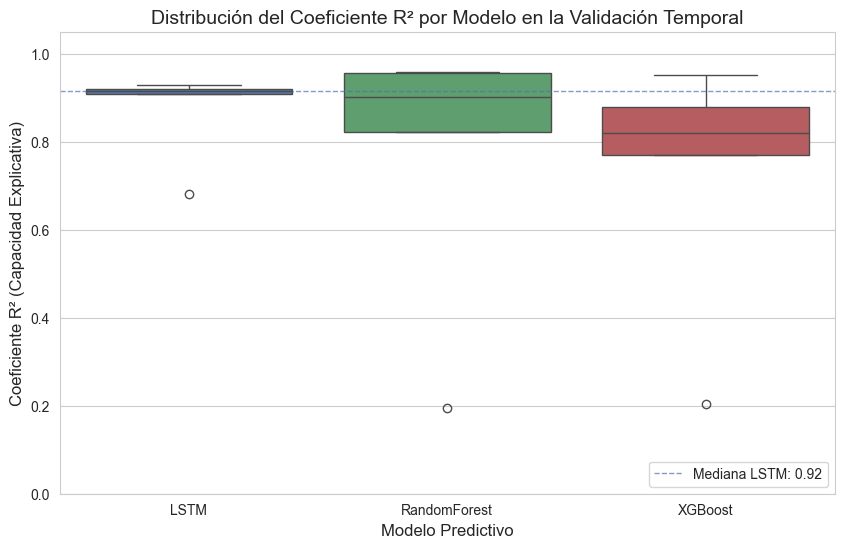

In [11]:
# 2. Filtrar solo los modelos funcionales para una visualización efectiva 
# (Excluir Prophet por sus valores R2 extremadamente negativos que distorsionan la escala)
df_functional = df_results[df_results['model'].isin(['LSTM', 'RandomForest', 'XGBoost'])].copy()

# 3. Definir el orden de los modelos basado en el rendimiento promedio (MAE/R2)
order = ['LSTM', 'RandomForest', 'XGBoost']

# 4. Generar el Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(
    x='model', 
    y='R2', 
    data=df_functional, 
    order=order,
    palette=['#4c72b0', '#55a868', '#c44e52'] # Paleta de colores distintivos
)

# 5. Añadir detalles al gráfico
plt.title('Distribución del Coeficiente R² por Modelo en la Validación Temporal', fontsize=14)
plt.ylabel('Coeficiente R² (Capacidad Explicativa)', fontsize=12)
plt.xlabel('Modelo Predictivo', fontsize=12)
plt.ylim(0, 1.05) # Escala forzada para R2 entre 0 y 1.05

# Añadir la mediana del LSTM para resaltar su estabilidad
lstm_median = df_functional[df_functional['model'] == 'LSTM']['R2'].median()
plt.axhline(lstm_median, color='#4c72b0', linestyle='--', linewidth=1, alpha=0.7, label=f'Mediana LSTM: {lstm_median:.2f}')
plt.legend(loc='lower right')

🚀 Iniciando pipeline de Prophet a nivel de país...


Procesando países:   0%|          | 0/41 [00:00<?, ?it/s]10:52:29 - cmdstanpy - INFO - Chain [1] start processing
10:52:30 - cmdstanpy - INFO - Chain [1] done processing
10:52:30 - cmdstanpy - INFO - Chain [1] start processing
10:52:31 - cmdstanpy - INFO - Chain [1] done processing
10:52:31 - cmdstanpy - INFO - Chain [1] start processing
10:52:32 - cmdstanpy - INFO - Chain [1] done processing
10:52:32 - cmdstanpy - INFO - Chain [1] start processing
10:52:32 - cmdstanpy - INFO - Chain [1] done processing
10:52:32 - cmdstanpy - INFO - Chain [1] start processing
10:52:32 - cmdstanpy - INFO - Chain [1] done processing
Procesando países:   2%|▏         | 1/41 [00:02<01:57,  2.93s/it]10:52:32 - cmdstanpy - INFO - Chain [1] start processing
10:52:33 - cmdstanpy - INFO - Chain [1] done processing
10:52:33 - cmdstanpy - INFO - Chain [1] start processing
10:52:39 - cmdstanpy - INFO - Chain [1] done processing
10:52:39 - cmdstanpy - INFO - Chain [1] start processing
10:52:40 - cmdstanpy - INFO - 

❌ Error procesando Mexico en fold 4: Input contains infinity or a value too large for dtype('float64').


Procesando países:  56%|█████▌    | 23/41 [04:10<03:35, 11.95s/it]10:56:40 - cmdstanpy - INFO - Chain [1] start processing
10:56:45 - cmdstanpy - INFO - Chain [1] done processing
10:56:45 - cmdstanpy - INFO - Chain [1] start processing
10:56:45 - cmdstanpy - INFO - Chain [1] done processing
10:56:45 - cmdstanpy - INFO - Chain [1] start processing
10:56:46 - cmdstanpy - INFO - Chain [1] done processing
10:56:47 - cmdstanpy - INFO - Chain [1] start processing
10:56:47 - cmdstanpy - INFO - Chain [1] done processing
Procesando países:  59%|█████▊    | 24/41 [04:17<02:57, 10.42s/it]10:56:47 - cmdstanpy - INFO - Chain [1] start processing
10:56:49 - cmdstanpy - INFO - Chain [1] done processing
10:56:49 - cmdstanpy - INFO - Chain [1] start processing
10:56:50 - cmdstanpy - INFO - Chain [1] done processing
10:56:50 - cmdstanpy - INFO - Chain [1] start processing
10:56:50 - cmdstanpy - INFO - Chain [1] done processing
10:56:50 - cmdstanpy - INFO - Chain [1] start processing
10:57:02 - cmdstanpy



📊 Resumen de Rendimiento de Prophet por País (media de métricas):
                                    MAE          RMSE             R2
country                                                             
Mongolia                   4.876391e+06  6.884808e+06  -5.449506e+00
Iceland                    8.870873e+05  8.987560e+05  -2.147750e+02
Switzerland                1.065306e+08  1.122806e+08  -5.278885e+02
Guinea                     3.720192e+14  5.261145e+14  -7.054804e+02
Portugal                   2.114686e+07  2.266076e+07  -3.148930e+03
Slovenia                   1.216233e+08  1.698265e+08  -1.153793e+05
Norway                     4.929221e+08  5.895635e+08  -2.166680e+05
Central African Republic   4.112137e+05  5.649580e+05  -4.413693e+05
Belgium                    1.111182e+08  1.321644e+08  -6.714877e+05
Chile                      2.208434e+08  3.117141e+08  -5.290852e+07
Spain                      1.493915e+10  1.503484e+10  -4.612886e+09
Slovak Republic            1.370407

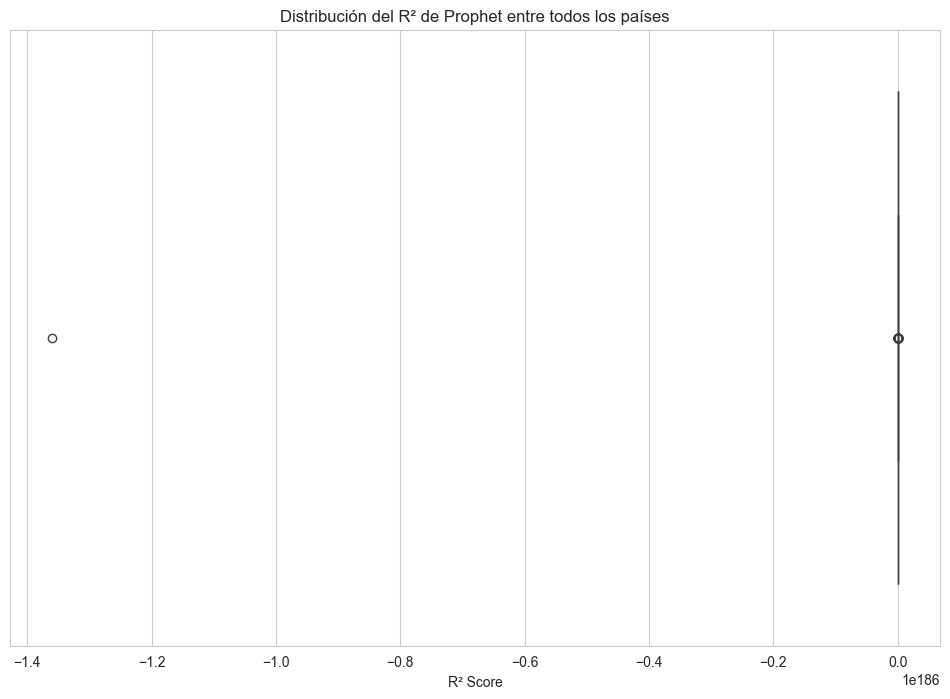

In [13]:
import os
# Ruta relativa a la carpeta de tu repositorio Git
repo_path = "/Users/ricardoortiz/Desktop/Maestria_CD/ProyectoAplicado/RepositorioGit"
file_path = os.path.join(repo_path, "df_results.csv")
df_results.to_csv(file_path, index=False, encoding="utf-8")

Pendientes: 

    INCLUIR SARIMAX DE TODOS MODOS, INTENTAR HACER UNA TRANSFORMACIÓN LOGARÍTMICA, SE PUEDE PONER SIN LA VALIDACIÓN DE SUPUESTOS. 
    TENER CUIDADO CON EL CROSS VALIDATION - Rehacer formula del MAPE porque los valores no son coherentes
    Aplicar rezagos en bloques. Se deben hacer modelos con diferentes rezagos. Tener en cuenta que se pierden observaciones. Tomar todas las X y rezagar todas y hasta 3 periodos. Si incluir y-1.
    